# Berrima Dealiasing

Dealiases a Berrima radar volume for use in multidop

In [32]:
import pyart
from matplotlib import pyplot as plt
from scipy import ndimage
import shutil, os
from datetime import timedelta, datetime
import numpy as np
import re
import time
import glob
from copy import deepcopy
from IPython.display import Image, display
%matplotlib inline
from mpl_toolkits import basemap
from netCDF4 import Dataset

In [44]:
input_file = '/home/rjackson/data/radar/berr/uncorrected/BerrimaVol20060123_132004.uf'
prev_file = '/home/rjackson/data/radar/berr/BerrimaVol20060123_003004deal.cf'

data_path_berr = '/home/rjackson/data/radar/berr/uncorrected/'
out_path_berr = '/home/rjackson/data/radar/berr/'
radar_image_path = '/home/rjackson/plots/berr_deal/'
output_file = '/home/rjackson/data/radar/berr/BerrimaVol20060123_004003_deal.uf'

sounding_input_file = '/home/rjackson/data/soundings/twpsondewnpnC3.b1.20060123.171600.custom.cdf'
data_path_sounding = '/home/rjackson/data/soundings/'

# Input the range of dates and time wanted for the collection of images
start_year = 2006
start_day = 23
start_month = 1
start_hour = 11
start_minute = 1
start_second = 0

end_year = 2006
end_month = 1
end_day = 23
end_hour = 18
end_minute = 00
end_second = 0


In [31]:
radar = pyart.io.read(input_file)



## 4DD requires the nyquist velocity be a field, 
## which is not in Berrima file
nyq = 9.75
nyquist_velocity = {'data': nyq*np.ones(radar.nrays,),
                    'meta_group': 'instrument_parameters',
                    'long_name': 'Nyquist velocity',
                    'units': 'm/s'}
radar.instrument_parameters['nyquist_velocity'] = nyquist_velocity
radar.info()

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	positive: up
	units: meters
	long_name: Altitude
	standard_name: Altitude
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float32 and shape: (6480,)>
	comment: Azimuth of antenna relative to true north
	axis: radial_azimuth_coordinate
	units: degrees
	long_name: azimuth_angle_from_true_north
	standard_name: beam_azimuth_angle
elevation:
	data: <ndarray of type: float32 and shape: (6480,)>
	comment: Elevation of antenna relative to the horizontal plane
	axis: radial_elevation_coordinate
	units: degrees
	long_name: elevation_angle_from_horizontal_plane
	standard_name: beam_elevation_angle
fields:
	velocity:
		data: <ndarray of type: float64 and shape: (6480, 511)>
		_FillValue: -9999.0
		units: meters_per_second
		long_name: Mean dopper velocity
		standard_name: radial_velocity_of_scatterers_away_from_instrument
		coordinates: elevation azimuth range
	corrected_reflectivity:
		data: <ndarray of typ

/home/rjackson/.local/lib/python3.5/site-packages/pyart/io/uf.py:223: UserWarning: Invalid wavelength, frequency set to default value.
  warnings.warn('Invalid wavelength, frequency set to default value.')


In [37]:
Sounding_netcdf = Dataset(sounding_input_file, mode='r')

# Convert timestamps to datetime format
Time = Sounding_netcdf.variables['time_offset'][:]
base_time = Sounding_netcdf.variables['base_time'][:]
alt = Sounding_netcdf.variables['alt'][:]
u = Sounding_netcdf.variables['u_wind'][:]
v = Sounding_netcdf.variables['v_wind'][:]
t = Sounding_netcdf.variables['tdry'][:]
v = v[u > -75]
alt = alt[u > -75]
u = u[u > -75]
wind_profile = pyart.core.HorizontalWindProfile.from_u_and_v(alt[0::5],
                                                             u[0::5],
                                                             v[0::5])
Sounding_netcdf.close()

(-100, 100)

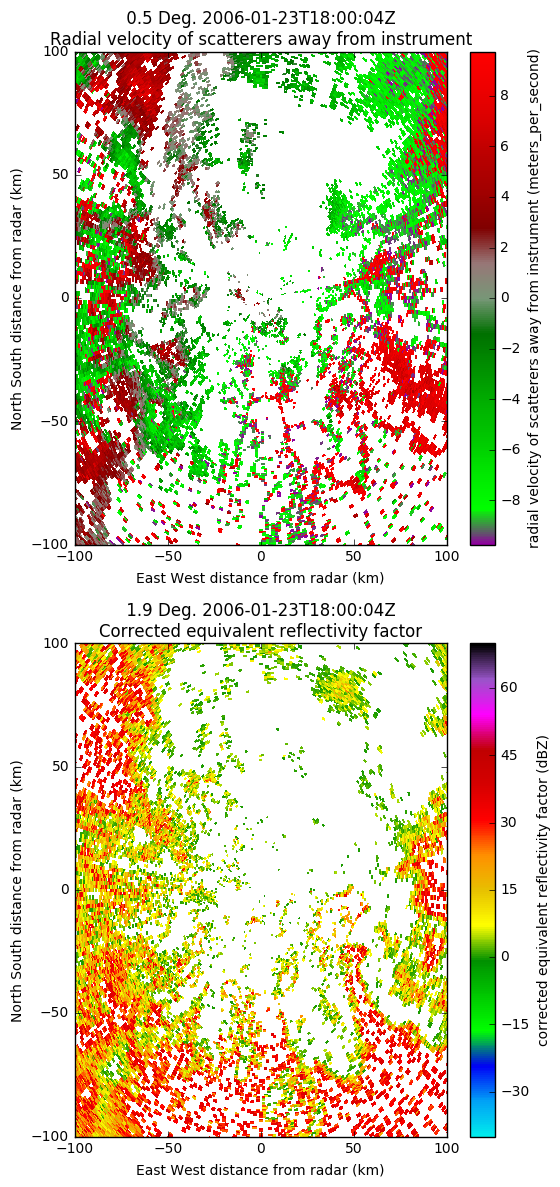

In [38]:
display = pyart.graph.RadarMapDisplay(radar)


gatefilter = pyart.correct.GateFilter(radar)
gatefilter.exclude_below('corrected_reflectivity', 0)

plt.figure(figsize=(6,14))
plt.subplot(211)
display.plot_ppi('velocity', sweep=0,
                 vmin=-nyq, vmax=nyq, cmap=pyart.graph.cm.NWSVel,
                 gatefilter=gatefilter)
plt.xlim([-100,100])
plt.ylim([-100,100])

plt.subplot(212)
display.plot_ppi('corrected_reflectivity', sweep=1,
                 vmin=-40, vmax=70, cmap=pyart.graph.cm.NWSRef,
                 gatefilter=gatefilter)
plt.xlim([-100,100])
plt.ylim([-100,100])

In [7]:
corrected_velocity_4dd = pyart.correct.dealias_fourdd(radar,
                                                      vel_field='velocity',
                                                      sonde_profile = wind_profile
                                                      )
radar.add_field_like('velocity', 
                     'corrected_velocity', 
                     corrected_velocity_4dd['data'],
                     replace_existing=True)

corrected_velocity_up = pyart.correct.dealias_unwrap_phase(radar,
                                                           vel_field='velocity',
                                                           sounding_heights = wind_profile.height,
                                                           sounding_wind_speeds = wind_profile.speed,
                                                           sounding_wind_direction = wind_profile.direction,
                                                           rays_wrap_around=True)
radar.add_field_like('velocity', 
                     'corrected_velocity_up', 
                     corrected_velocity_up['data'],
                     replace_existing=True)

corrected_velocity_region = pyart.correct.dealias_region_based(radar,
                                                               vel_field='velocity',
                                                               sonde_profile=wind_profile,
                                                               rays_wrap_around=True,
                                                               centered=True,
                                                               interval_splits=4)
radar.add_field_like('velocity', 
                     'corrected_velocity_region', 
                     corrected_velocity_region['data'],
                     replace_existing=True)

## Plot the sounding

I use this as a way to verify that the final dealiased results make sense in terms of the wind directions. 
I noticed that phase unwrapping and 4DD will give winds in the opposite directions. The sounding below gives winds going to the west-northwest, so the corrected velocities should, on average, reflect that. 

(0, 10000)

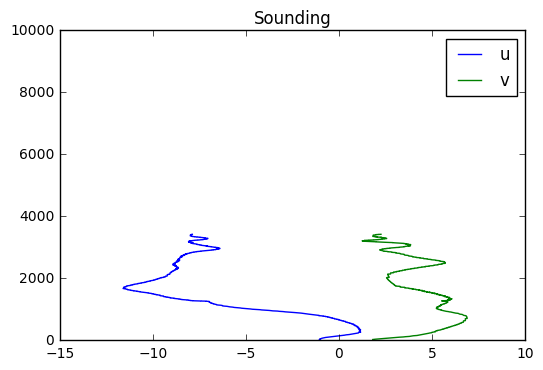

In [8]:
plt.plot(u,alt)
plt.plot(v,alt)
plt.legend(['u','v'])
plt.title('Sounding')
plt.ylim([0, 10000])

## Compare 4DD and phase unwrapping

4DD has velocities away from the radar negative to the southeast and positive to the northwest, reflecting southeasterly flow (winds going to the northwest). The phase unwrapping algorithm has these going in the opposite direction. The region based algorithms has all of the the winds converging towards the radar, which is unrealistic. The 4DD algorithm is more consistent with what would be expected from the sounding.

(-100, 100)

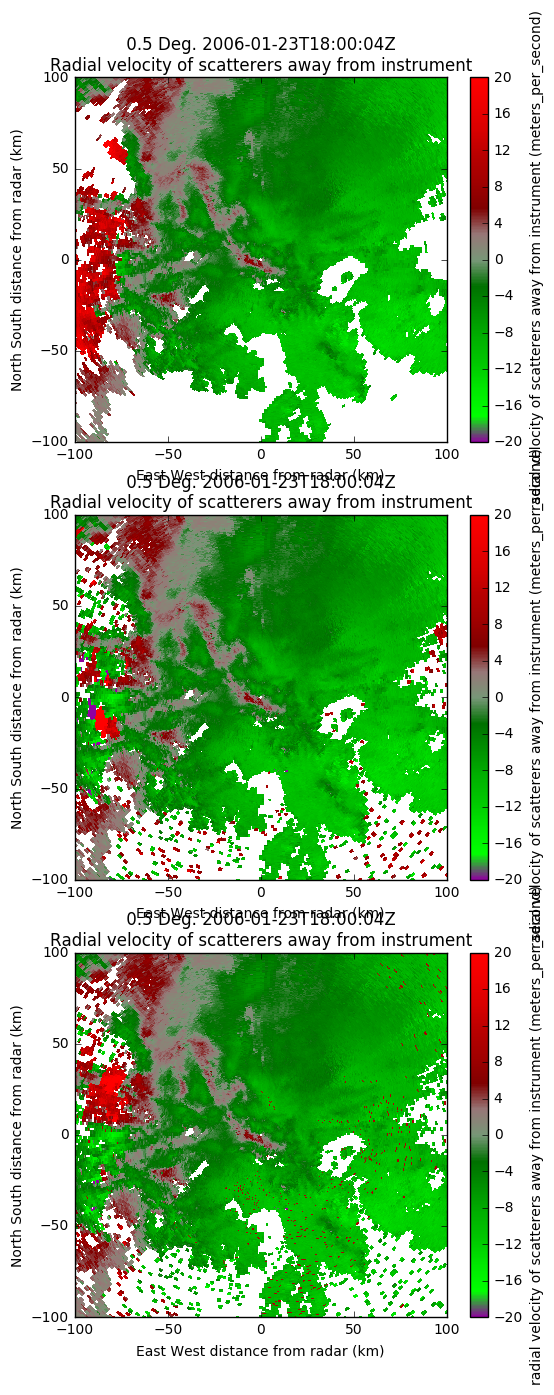

In [9]:
plt.figure(figsize=(6,16))
plt.subplot(311)
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi('corrected_velocity', sweep=0,
                 vmin=-20, vmax=20, cmap=pyart.graph.cm.NWSVel)
plt.xlim([-100,100])
plt.ylim([-100,100])

plt.subplot(312)
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi('corrected_velocity_up', sweep=0,
                 vmin=-20, vmax=20, cmap=pyart.graph.cm.NWSVel)
plt.xlim([-100,100])
plt.ylim([-100,100])

plt.subplot(313)
display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi('corrected_velocity_region', sweep=0,
                 vmin=-20, vmax=20, cmap=pyart.graph.cm.NWSVel)
plt.xlim([-100,100])
plt.ylim([-100,100])

## Batch process dealiasing with images

In [21]:
data = ndimage.filters.generic_filter(radar.fields['velocity']['data'],
                                      pyart.util.interval_std, size = (3,3),
                                      extra_arguments = (-nyq, nyq))
filtered_data = ndimage.filters.median_filter(data, size = (3,3))
texture_field = pyart.config.get_metadata('velocity')
texture_field['data'] = filtered_data
radar.add_field('reflectivity_texture', texture_field, replace_existing = True)



(-100, 100)

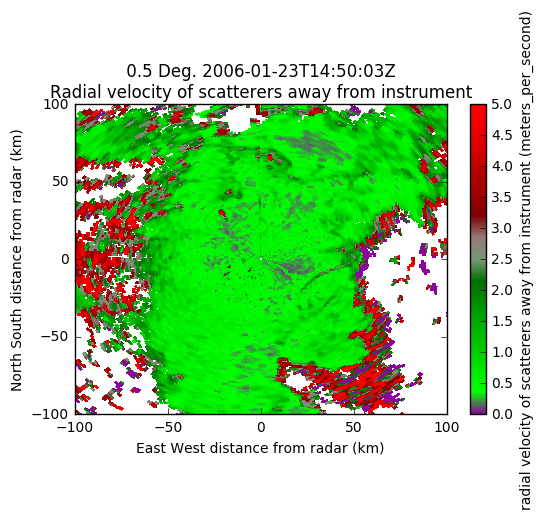

In [27]:
x = radar.fields['reflectivity_texture']['data']

plt.figure()

display = pyart.graph.RadarMapDisplay(radar)
display.plot_ppi('reflectivity_texture', sweep=0, gatefilter=gatefilter,
                     vmin=0, vmax=5, cmap=pyart.graph.cm.NWSVel)
plt.xlim([-100,100])
plt.ylim([-100,100])

In [16]:
# get_radar_times
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of Radar classes between start_time and end_time  
def get_radar_times_berr(start_year, start_month, start_day,
                        start_hour, start_minute, end_year,
                        end_month, end_day, end_hour, 
                        end_minute, minute_interval=5):

    start_time = datetime(start_year,
                          start_month,
                          start_day,
                          start_hour,
                          start_minute,
                          )
    end_time = datetime(end_year,
                        end_month,
                        end_day,
                        end_hour,
                        end_minute,
                        )

    deltatime = end_time - start_time


    if(deltatime.seconds > 0 or deltatime.minute > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = np.arange(0, no_days, 1)
    print('We are about to load grid files for ' + str(no_days) + ' days')
    

    # Find the list of files for each day
    cur_time = start_time
    
    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path_berr +
                      'BerrimaVol' +
                      year_str +
                      month_str +
                      day_str +
                      '_*.uf')
    
    
        print('Looking for files with format ' + format_str)
          
        data_list = glob.glob(data_path_berr +
                              'BerrimaVol' +
                              year_str +
                              month_str +
                              day_str +
                              '_*.uf')
        
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
    
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        date_str = file_name[-18:-3]
        
        year_str = date_str[0:4]
        month_str = date_str[4:6]
        day_str = date_str[6:8]
        hour_str = date_str[9:11]
        minute_str = date_str[11:13]
        second_str = date_str[13:15]
               
        
        
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            int(second_str))
        time_list.append(cur_time)
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
    
    
    for times in time_list_sorted: 
        
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
           
            
            
    
    return time_list_final

# Get a Radar object given a time period in the CPOL dataset
def get_radar_from_berr(time):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (data_path_berr +
                     'BerrimaVol' +
                     year_str +
                     month_str +
                     day_str +
                     '_' +
                     hour_str +
                     minute_str +
                     second_str +
                     '.uf')
    print(file_name_str)    
    radar = pyart.io.read(file_name_str)
    return radar

def save_radar_deal_berr(time, radar):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (out_path_berr +
                     'BerrimaVol' +
                     year_str +
                     month_str +
                     day_str +
                     '_' +
                     hour_str +
                     minute_str +
                     second_str +
                     '_deal.cf')
    pyart.io.write_cfradial(file_name_str, radar)


def load_radar_deal_berr(time):
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (out_path_berr +
                     'BerrimaVol' +
                     year_str +
                     month_str +
                     day_str +
                     '_' +
                     hour_str +
                     minute_str +
                     second_str +
                     '_deal.cf')
    pyart.io.read(file_name_str, radar)
    return radar

# get_sounding_times
#     start_year = Start year of animation
#     start_month = Start month of animation
#     start_day = Start day of animation
#     start_hour = Start hour of animation
#     end_year = End year of animation
#     end_month = End month of animation
#     end_day = End day of animation
#     end_minute = End minute of animation
#     minute_interval = Interval in minutes between scans (default is 5)
# This procedure acquires an array of sounding times between start_time and end_time. 
def get_sounding_times(start_year, start_month, start_day,
                       start_hour, start_minute, end_year,
                       end_month, end_day, end_hour, 
                       end_minute, minute_interval=5):

    from datetime import timedelta, datetime
    start_time = datetime(start_year,
                          start_month,
                          start_day,
                          start_hour,
                          start_minute,
                          )
    end_time = datetime(end_year,
                        end_month,
                        end_day,
                        end_hour,
                        end_minute,
                        )
    deltatime = end_time - start_time
  
    if(deltatime.seconds > 0 or deltatime.minutes > 0):
        no_days = deltatime.days + 1
    else:
        no_days = deltatime.days
    
    if(start_day != end_day):
        no_days = no_days + 1
        
    days = np.arange(0, no_days, 1)
    print('We are about to load sounding files for ' + str(no_days) + ' days')
    
    # Find the list of files for each day
    cur_time = start_time

    file_list = []
    time_list = []
    for i in days:
        year_str = "%04d" % cur_time.year
        day_str = "%02d" % cur_time.day
        month_str = "%02d" % cur_time.month
        format_str = (data_path_sounding +
                      'twpsondewnpnC3.b1.' +
                      year_str +
                      month_str +
                      day_str +
                      '*custom.cdf')
    
          
        data_list = glob.glob(format_str)
        
        for j in range(0, len(data_list)):
            file_list.append(data_list[j])
        cur_time = cur_time + timedelta(days=1)
        
   
    # Parse all of the dates and time in the interval and add them to the time list
    past_time = []
    for file_name in file_list:
        date_str = file_name[-26:-11]  
        year_str = date_str[0:4]
        month_str = date_str[4:6]
        day_str = date_str[6:8]
        hour_str = date_str[9:11]
        minute_str = date_str[11:13]
        second_str = date_str[13:15]
                
        cur_time = datetime(int(year_str),
                            int(month_str),
                            int(day_str),
                            int(hour_str),
                            int(minute_str),
                            int(second_str))
        time_list.append(cur_time)
    
    # Sort time list and make sure time are at least xx min apart
    time_list.sort()
    time_list_sorted = deepcopy(time_list)
   
    time_list_final = []
    past_time = []
    
    for times in time_list_sorted: 
        
        cur_time = times  
        
        if(past_time == []):
            past_time = cur_time
            
        if(cur_time - past_time >= timedelta(minutes=minute_interval)
           and cur_time >= start_time and cur_time <= end_time):
            
            time_list_final.append(cur_time)
            past_time = cur_time
               
    return time_list_final

# Get a sounding object given a time period in the CPOL dataset
def get_sounding(time):
    from datetime import timedelta, datetime
    from netCDF4 import Dataset
    year_str = "%04d" % time.year
    month_str = "%02d" % time.month
    day_str = "%02d" % time.day
    hour_str = "%02d" % time.hour
    minute_str = "%02d" % time.minute
    second_str = "%02d" % time.second
    file_name_str = (data_path_sounding +
                     'twpsondewnpnC3.b1.' +
                     year_str +
                     month_str +
                     day_str +
                     '.' +
                     hour_str +
                     minute_str +
                     second_str +
                     '.custom.cdf')
    sounding = Dataset(file_name_str, mode='r')
    return sounding

First successfully dealiased frame = 01-21 01:10

In [45]:
times_berr = get_radar_times_berr(start_year, start_month, start_day,
                                  start_hour, start_minute, end_year,
                                  end_month, end_day, end_hour, 
                                  end_minute, minute_interval=1)

plt.figure(figsize=(6,6))
last_Radar = []

for times in times_berr:
    one_day_ago = times-timedelta(days=1, minutes=1)
    sounding_times = get_sounding_times(one_day_ago.year,
                                        one_day_ago.month,
                                        one_day_ago.day,
                                        one_day_ago.hour,
                                        one_day_ago.minute,
                                        times.year,
                                        times.month,
                                        times.day,
                                        times.hour,
                                        times.minute,
                                        minute_interval=60)
    sounding_time = sounding_times[len(sounding_times)-1]
    Sounding_netcdf = get_sounding(sounding_time)
    print(sounding_time)
    # Load sounding data
    Time = Sounding_netcdf.variables['time_offset'][:]
    base_time = Sounding_netcdf.variables['base_time'][:]
    alt = Sounding_netcdf.variables['alt'][:]
    u = Sounding_netcdf.variables['u_wind'][:]
    v = Sounding_netcdf.variables['v_wind'][:]
    t = Sounding_netcdf.variables['tdry'][:]
    spd = Sounding_netcdf.variables['wspd'][:]
    deg = Sounding_netcdf.variables['deg'][:]
    spd = spd[u > -75]
    deg = deg[u > -75]
    v = v[u > -75]
    alt = alt[u > -75]
    u = u[u > -75]
    
    
    steps = np.floor(len(u)/50)
    #steps=5
    wind_profile = pyart.core.HorizontalWindProfile.from_u_and_v(alt[0::steps],
                                                                 u[0::steps],
                                                                 v[0::steps])
    
    ## 4DD expects speed, direction but HorizontalWindProfile outputs u_wind, v_wind
    wind_profile.u = wind_profile.u_wind
    wind_profile.v = wind_profile.v_wind
    Sounding_netcdf.close()
    
    radar = get_radar_from_berr(times)
    
    ## 4DD requires the nyquist velocity be a field, 
    ## which is not in Berrima file
    nyq = 9.75
    nyquist_velocity = {'data': nyq*np.ones(radar.nrays,),
                        'meta_group': 'instrument_parameters',
                        'long_name': 'Nyquist velocity',
                        'units': 'm/s'}
    radar.instrument_parameters['nyquist_velocity'] = nyquist_velocity
    
    #data = ndimage.filters.generic_filter(radar.fields['velocity']['data'],
    #                                      pyart.util.interval_std, size = (6,6),
    #                                      extra_arguments = (-nyq, nyq))
    #filtered_data = ndimage.filters.median_filter(data, size = (3,3))
    #texture_field = pyart.config.get_metadata('velocity')
    #texture_field['data'] = filtered_data
    #radar.add_field('velocity_texture', texture_field, replace_existing = True)
    
    gatefilter = pyart.correct.despeckle.despeckle_field(radar,
                                                         'velocity')
    #gatefilter.exclude_above('velocity_texture', 2)

    # Do 4DD on scan
    try:
        corrected_velocity_4dd = pyart.correct.dealias_region_based(radar,
                                                                    vel_field='velocity',
                                                                    last_radar=last_Radar,
                                                                    gatefilter=gatefilter,
                                                                    sonde_profile=wind_profile,
                                                                    centered=True,
                                                                    keep_original=False)
    except:
        corrected_velocity_4dd = pyart.correct.dealias_region_based(radar,
                                                                    vel_field='velocity',
                                                                    gatefilter=gatefilter,
                                                                    sonde_profile=wind_profile,
                                                                    centered=True,
                                                                    keep_original=False)
    radar.add_field_like('velocity', 
                         'corrected_velocity', 
                          corrected_velocity_4dd['data'],
                          replace_existing=True)
    
    # Save new radar file
    save_radar_deal_berr(times, radar)
    
    # Output image to file
    plt.figure(figsize=(6,14))
    plt.subplot(211)
    display = pyart.graph.RadarMapDisplay(radar)
    display.plot_ppi('corrected_reflectivity', sweep=0, gatefilter=gatefilter,
                     vmin=-10, vmax=70, cmap=pyart.graph.cm.NWSRef)
    plt.xlim([-100,100])
    plt.ylim([-100,100])
    
    plt.subplot(212)
    display = pyart.graph.RadarMapDisplay(radar)
    display.plot_ppi('corrected_velocity', sweep=0, gatefilter=gatefilter,
                     vmin=-20, vmax=20, cmap=pyart.graph.cm.NWSVel)
    plt.xlim([-100,100])
    plt.ylim([-100,100])
    mean_vel = np.mean(radar.fields['corrected_velocity']['data'])
    plt.title('Corrected velocity mean = ' + str(mean_vel))
    plt.savefig((radar_image_path +
                 "%04d" % times.year +
                 "%02d" % times.month + 
                 "%02d" % times.day + 
                 "%02d" % times.hour +
                 "%02d" % times.minute + '.png'))
    plt.close()
    last_Radar = load_radar_deal_berr(times)

We are about to load grid files for 1 days
Looking for files with format /home/rjackson/data/radar/berr/uncorrected/BerrimaVol20060123_*.uf
We are about to load sounding files for 3 days
2006-01-23 05:25:00
/home/rjackson/data/radar/berr/uncorrected/BerrimaVol20060123_111004.uf


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:44: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/rjackson/.local/lib/python3.5/site-packages/pyart/io/uf.py:223: UserWarning: Invalid wavelength, frequency set to default value.
  warnings.warn('Invalid wavelength, frequency set to default value.')
/home/rjackson/.local/lib/python3.5/site-packages/pyart/correct/despeckle.py:201: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  old_labs = np.uni

We are about to load sounding files for 3 days
2006-01-23 11:17:00
/home/rjackson/data/radar/berr/uncorrected/BerrimaVol20060123_112003.uf
We are about to load sounding files for 3 days
2006-01-23 11:17:00
/home/rjackson/data/radar/berr/uncorrected/BerrimaVol20060123_113004.uf
We are about to load sounding files for 3 days
2006-01-23 11:17:00
/home/rjackson/data/radar/berr/uncorrected/BerrimaVol20060123_114003.uf
We are about to load sounding files for 3 days
2006-01-23 11:17:00
/home/rjackson/data/radar/berr/uncorrected/BerrimaVol20060123_115003.uf
We are about to load sounding files for 3 days
2006-01-23 11:17:00
/home/rjackson/data/radar/berr/uncorrected/BerrimaVol20060123_120003.uf
We are about to load sounding files for 3 days
2006-01-23 11:17:00
/home/rjackson/data/radar/berr/uncorrected/BerrimaVol20060123_121004.uf
We are about to load sounding files for 3 days
2006-01-23 11:17:00
/home/rjackson/data/radar/berr/uncorrected/BerrimaVol20060123_122004.uf
We are about to load soundi